In [52]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from tqdm.notebook import tqdm

<div class="alert alert-block alert-success">
<b>Success:</b> Great that all imports are collected at the top of the notebook!
</div>

**1.1. Open the files and look into the data.**

In [2]:
df1 = pd.read_csv('/datasets/gold_recovery_train.csv',parse_dates=True,index_col='date')
df2 = pd.read_csv('/datasets/gold_recovery_test.csv',parse_dates=True,index_col='date')
df3 = pd.read_csv('/datasets/gold_recovery_full.csv', parse_dates=True, index_col='date')

I will drop and not try to fill the missing values, because this might hurt the model

In [3]:
df1.dropna(inplace=True)
df2.dropna(inplace=True)
df3.dropna(inplace=True)

<div class="alert alert-block alert-success">
<b>Success:</b> One of the possible solutions.
</div>

**1.2. Check that recovery is calculated correctly. Using the training set, calculate recovery for the rougher.output.recovery feature. Find the MAE between your calculations and the feature values. Provide findings.**

assign variables

In [4]:
C= df1['rougher.output.concentrate_au']
F= df1['rougher.input.feed_au']
T= df1['rougher.output.tail_au']

calculate recovery

In [5]:
recovery = ((C * (F-T)) / (F * (C-T))) * 100

**Find the MAE between your calculations and the feature values. Provide findings.**

In [6]:
mean_absolute_error(recovery,df1['rougher.output.recovery'])

9.555596961987514e-15

This is a really small number, thus rougher.output.recovery is calculated well

<div class="alert alert-block alert-success">
<b>Success:</b> Absolutely right!
</div>

**Analyze the features not available in the test set. What are these parameters? What is their type?**

there are 34 less features in the test set, these are the final. features and all the output features they are all floats.

**1.4. Perform data preprocessing.**

I made a new test dataset with all features from the train data

In [7]:
df4 = df3.loc[df2.index]

**2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.**

for this I will use the full dataset first lets plot for 4 stages of AU

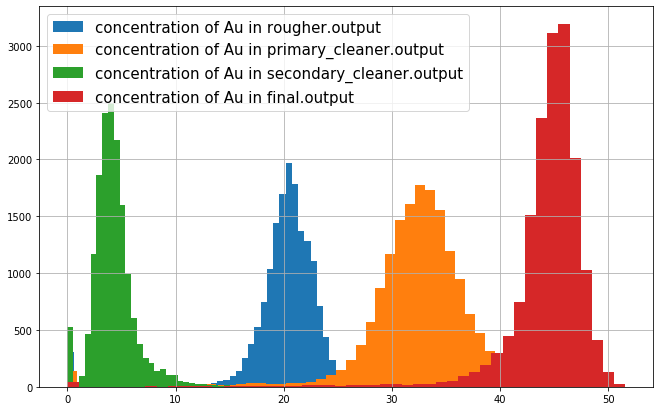

In [8]:
plt.figure(figsize=(11,7))
plt.hist(df3['rougher.output.concentrate_au'],label = 'concentration of Au in rougher.output',bins = 50)
plt.hist(df3['primary_cleaner.output.concentrate_au'],label = 'concentration of Au in primary_cleaner.output',bins = 50)
plt.hist(df3['secondary_cleaner.output.tail_au'],label = 'concentration of Au in secondary_cleaner.output',bins = 50)
plt.hist(df3['final.output.concentrate_au'],label = 'concentration of Au in final.output',bins = 50)
plt.legend(fontsize=15)
plt.grid()
plt.show()

now lets plot AG

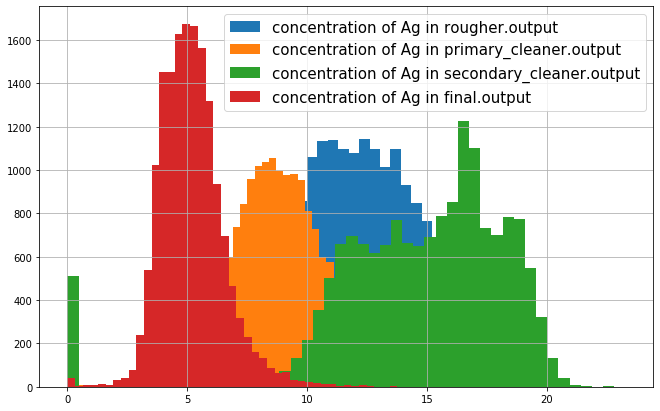

In [9]:
plt.figure(figsize=(11,7))
plt.hist(df3['rougher.output.concentrate_ag'],label = 'concentration of Ag in rougher.output',bins = 50)
plt.hist(df3['primary_cleaner.output.concentrate_ag'],label = 'concentration of Ag in primary_cleaner.output',bins = 50)
plt.hist(df3['secondary_cleaner.output.tail_ag'],label = 'concentration of Ag in secondary_cleaner.output',bins = 50)
plt.hist(df3['final.output.concentrate_ag'],label = 'concentration of Ag in final.output',bins = 50)
plt.legend(fontsize=15)
plt.grid()
plt.show()

now lets plot Pb

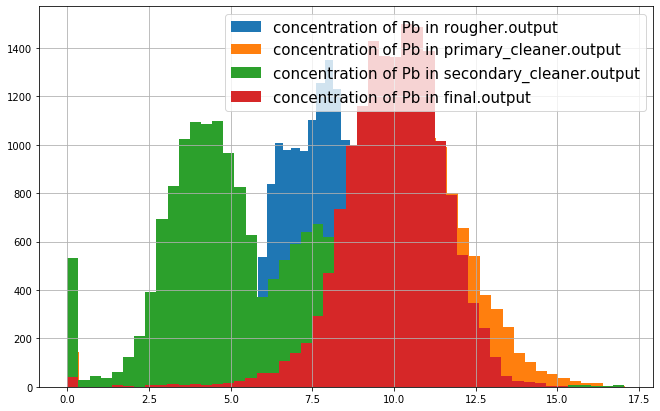

In [10]:
plt.figure(figsize=(11,7))
plt.hist(df3['rougher.output.concentrate_pb'],label = 'concentration of Pb in rougher.output',bins = 50)
plt.hist(df3['primary_cleaner.output.concentrate_pb'],label = 'concentration of Pb in primary_cleaner.output',bins = 50)
plt.hist(df3['secondary_cleaner.output.tail_pb'],label = 'concentration of Pb in secondary_cleaner.output',bins = 50)
plt.hist(df3['final.output.concentrate_pb'],label = 'concentration of Pb in final.output',bins = 50)
plt.legend(fontsize=15)
plt.grid()
plt.show()

<div class="alert alert-block alert-success">
<b>Success:</b> Well done!
</div>

**2.2. Compare the feed particle size distributions in the training set and in the test set. If the distributions vary significantly, the model evaluation will be incorrect.**

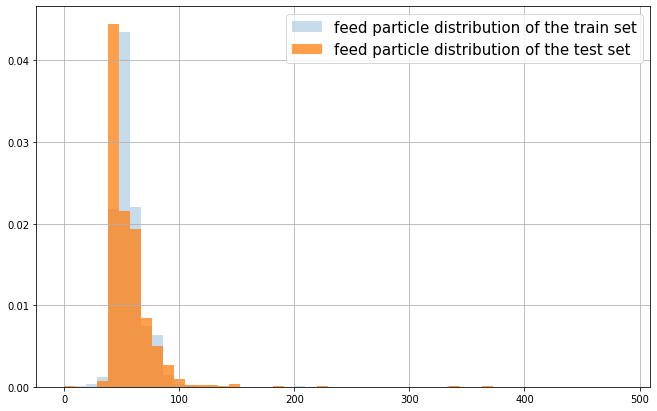

In [11]:
plt.figure(figsize=(11,7))
plt.hist(df1['rougher.input.feed_size'],label = 'feed particle distribution of the train set',bins = 50,density=True,alpha = 0.25)
plt.hist(df2['rougher.input.feed_size'],label = 'feed particle distribution of the test set',bins = 50,density=True,alpha = 0.75)
plt.legend(fontsize=15)
plt.grid()
plt.show()

they dont vary significantly

<div class="alert alert-block alert-success">
<b>Success:</b> You are right!
</div>

**2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate. Do you notice any abnormal values in the total distribution? If you do, is it worth removing such values from both samples? Describe the findings and eliminate anomalies.**

let's start with raw feed, and plot histogram

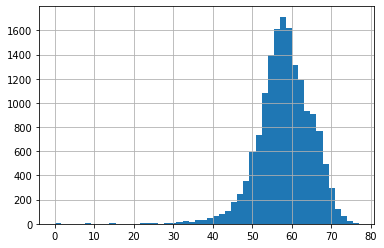

In [12]:
features_raw_feed = ['rougher.input.feed_au','rougher.input.feed_ag','rougher.input.feed_pb','rougher.input.feed_sol']
df3[features_raw_feed].sum(1).hist(bins=50)

There are some outliers

In [13]:
df4 = df4[df4[features_raw_feed].sum(1)>35]
df1 = df1[df1[features_raw_feed].sum(1)>35]
df3 = df3[df3[features_raw_feed].sum(1)>35]

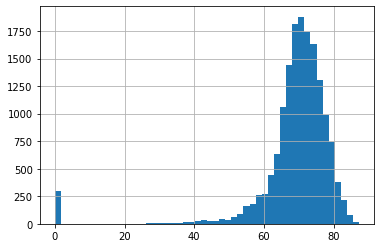

In [14]:
features_rougher_output = ['rougher.output.concentrate_ag','rougher.output.concentrate_pb','rougher.output.concentrate_au','rougher.output.concentrate_sol']
df3[features_rougher_output].sum(1).hist(bins=50)

there are some outliers before 20

In [15]:
df4 = df4[df4[features_rougher_output].sum(1)>20]
df1 = df1[df1[features_rougher_output].sum(1)>20]
df3 = df3[df3[features_rougher_output].sum(1)>20]

Now a histogram for final concentrate

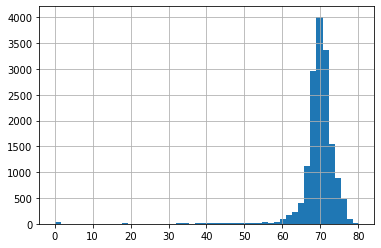

In [16]:
features_final_concentrate = ['final.output.concentrate_ag','final.output.concentrate_pb','final.output.concentrate_au','final.output.concentrate_sol']
df3[features_final_concentrate].sum(1).hist(bins=50)

In [17]:
df4 = df4[df4[features_final_concentrate].sum(1)>55]
df1 = df1[df1[features_final_concentrate].sum(1)>55]
df3 = df3[df3[features_final_concentrate].sum(1)>55]

there are some outliers before 55

<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> Please eliminate the errors.
</div>

errors are eliminated and now I will define the features

In [18]:
scaler = StandardScaler()

features_train = df1.drop(['rougher.output.recovery','final.output.recovery'],axis=1)
target_train = df1[['rougher.output.recovery','final.output.recovery']]
features_test = df4.drop(['rougher.output.recovery','final.output.recovery'],axis=1)
target_test = df4[['rougher.output.recovery','final.output.recovery']]
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

**3.1. Write a function to calculate the final sMAPE value.**

I will write a function for sMAPE and final sMAPE separately

In [19]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [20]:
def final_smape(rougher,final):
    return rougher * 0.25 + final * 0.75

**3.2. Train different models. Evaluate them using cross-validation. Pick the best model and test it using the test sample. Provide findings.**

In [21]:
target_train = np.array(target_train)
target_test = np.array(target_test)

In [22]:
model = LinearRegression()
model.fit(features_train,target_train[:,0])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

<div class="alert alert-block alert-danger">
<b>Needs fixing (review 2):</b> 'features_train' and 'target_train' are with errors because they are defined before errors are eliminated.
</div>

I fixed the issue

<div class="alert alert-block alert-danger">
<b>Needs fixing (review 2):</b> Both Logistic Regression and RF classifier are used in the classification tasks. Check the current target feature please and define the task type.
</div>

In [23]:
predict = model.predict(features_test)

In [24]:
rougher = smape(predict,target_test[:,0])

In [25]:
model.fit(features_train,target_train[:,1])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [26]:
final =  smape(predict,target_test[:,1])

In [27]:
final_smape(rougher,final)

17.68738836518777

with linear regression model I am just getting 17.69 final smape, lets try Random Forest Regressor with different hyperparameters different models

In [38]:
for i in range(10,101,10):
    model = RandomForestRegressor(random_state=12345,n_estimators = i,max_depth=10)
    model.fit(features_train,target_train)
    predict = model.predict(features_test)
    rougher_pred = predict[:,0]
    final_pred = predict[:,1]
    rougher = smape(rougher_pred,target_test[:,0])
    final = smape(final_pred,target_test[:,1])
    
    print("n_estimators =", i, ": ", end='')
    print(final_smape(rougher,final))

n_estimators = 10 : 2.0699005501038985
n_estimators = 20 : 2.022995199244353
n_estimators = 30 : 1.9669716051607329
n_estimators = 40 : 1.8945104651236022
n_estimators = 50 : 1.8811608523280086
n_estimators = 60 : 1.8650789613625434
n_estimators = 70 : 1.84143270574083
n_estimators = 80 : 1.85079873202154
n_estimators = 90 : 1.8500229666422452
n_estimators = 100 : 1.8505335159929954


I got the lowest score with 70 estimators

In [39]:
smape_scorer = make_scorer(smape, greater_is_better = False)

now that I registered my scorer with the make_scorer function lets try to use cross validate with random forest classifier with 70 estimators

<div class="alert alert-block alert-danger">
<b>Needs fixing (review 3):</b> if target is continuous than it's regression task and RandomForestRegressor should be used.
</div>

In [40]:
model = RandomForestRegressor(random_state=12345,n_estimators = 70,max_depth=10)

In [46]:
score_rougher = cross_validate(model,features_train,target_train[:,0],scoring = smape_scorer,cv=5)

In [48]:
score_final  = cross_validate(model,features_train,target_train[:,1],scoring = smape_scorer,cv=5)

In [49]:
score_rougher = score_rougher['test_score'].mean()

In [50]:
score_final = score_final['test_score'].mean()

<div class="alert alert-block alert-danger">
<b>Needs fixing (review 3):</b> Selecting min is not a good idea. It's better to use .mean()
</div>

In [51]:
final_smape(score_rougher,score_final)

-1.4071373242644731

I got the negative smape value,lastly I will test the catboost model

In [53]:
model = CatBoostRegressor(random_seed=12345)

In [55]:
model.fit(features_train,target_train[:,0])
predict = model.predict(features_test)

0:	learn: 7.0886122	total: 117ms	remaining: 1m 56s
1:	learn: 6.9383039	total: 217ms	remaining: 1m 48s
2:	learn: 6.7800695	total: 322ms	remaining: 1m 46s
3:	learn: 6.6290439	total: 425ms	remaining: 1m 45s
4:	learn: 6.4974040	total: 614ms	remaining: 2m 2s
5:	learn: 6.3529576	total: 717ms	remaining: 1m 58s
6:	learn: 6.2097470	total: 818ms	remaining: 1m 56s
7:	learn: 6.0795389	total: 1.01s	remaining: 2m 4s
8:	learn: 5.9521244	total: 1.11s	remaining: 2m 2s
9:	learn: 5.8235547	total: 1.21s	remaining: 1m 59s
10:	learn: 5.7086088	total: 1.31s	remaining: 1m 57s
11:	learn: 5.5786217	total: 1.41s	remaining: 1m 56s
12:	learn: 5.4692916	total: 1.51s	remaining: 1m 54s
13:	learn: 5.3543468	total: 1.61s	remaining: 1m 53s
14:	learn: 5.2365623	total: 1.72s	remaining: 1m 52s
15:	learn: 5.1351355	total: 1.9s	remaining: 1m 56s
16:	learn: 5.0236285	total: 2s	remaining: 1m 55s
17:	learn: 4.9224948	total: 2.11s	remaining: 1m 54s
18:	learn: 4.8293251	total: 2.21s	remaining: 1m 54s
19:	learn: 4.7309473	total: 2

In [56]:
rougher = smape(predict,target_test[:,0])

In [57]:
model.fit(features_train,target_train[:,1])
predict = model.predict(features_test)

0:	learn: 7.7542650	total: 96.1ms	remaining: 1m 35s
1:	learn: 7.6122622	total: 195ms	remaining: 1m 37s
2:	learn: 7.4720544	total: 300ms	remaining: 1m 39s
3:	learn: 7.3372282	total: 403ms	remaining: 1m 40s
4:	learn: 7.2070243	total: 510ms	remaining: 1m 41s
5:	learn: 7.0897965	total: 691ms	remaining: 1m 54s
6:	learn: 6.9581352	total: 792ms	remaining: 1m 52s
7:	learn: 6.8314080	total: 896ms	remaining: 1m 51s
8:	learn: 6.7044732	total: 997ms	remaining: 1m 49s
9:	learn: 6.5827245	total: 1.1s	remaining: 1m 48s
10:	learn: 6.4631635	total: 1.2s	remaining: 1m 47s
11:	learn: 6.3442835	total: 1.39s	remaining: 1m 54s
12:	learn: 6.2333086	total: 1.49s	remaining: 1m 53s
13:	learn: 6.1217243	total: 1.59s	remaining: 1m 52s
14:	learn: 6.0167767	total: 1.7s	remaining: 1m 51s
15:	learn: 5.9219524	total: 1.88s	remaining: 1m 55s
16:	learn: 5.8229853	total: 1.98s	remaining: 1m 54s
17:	learn: 5.7340800	total: 2.09s	remaining: 1m 53s
18:	learn: 5.6477623	total: 2.19s	remaining: 1m 53s
19:	learn: 5.5521488	tot

In [58]:
final =  smape(predict,target_test[:,1])

In [59]:
final_smape(rougher,final)

0.4931994533423776

After all I got the lowest smape value 0.4931994533423776 with catboostregressor, however with crossvalidation I got the negative value